<a href="https://colab.research.google.com/github/dunnohow/Bert/blob/master/bluehouseblah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

</br>
</br>

#**Initialize**

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 8.0MB/s 
     |████████████████████████████████| 890kB 23.9MB/s 
     |████████████████████████████████| 1.1MB 44.4MB/s 
     |████████████████████████████████| 3.0MB 27.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7455d88393d4425ea662ac6bd98d7c88800cc594db0e55a46270127e389a8266
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertModel, BertTokenizer # load language model & tokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup


import random
from tqdm.notebook import tqdm
import re
import time
import datetime
import numpy as np
import pandas as pd
from pandas.core.common import flatten
from itertools import compress
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<br>
<br>

#**Load Data (청와대 청원 데이터)**

<br>

https://dacon.io/competitions/open/235597/overview/

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
path = "drive/My Drive/NLP_practice/Blue-House/"
os.listdir(path)

['train.csv',
 'sample_submission.csv',
 'test.csv',
 'data.csv',
 'bluehouseblah.ipynb']

In [ ]:
# 그래프에 retina display 적용
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [ ]:
# Mecab 다운로드
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 23), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [ ]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.5MB/s 
     |████████████████████████████████| 3.6MB 54.6MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-07-15 04:21:09--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.1, 18.205.93.0, 18.205.93.2, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?

In [ ]:
from konlpy.tag import Mecab

In [ ]:
train.iloc[:,1].value_counts()

2    13362
1    13337
0    13301
Name: category, dtype: int64

In [ ]:
train.head()

,index,category,data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


In [ ]:
test.head()

,index,data
0,0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."


In [ ]:
len(test)

5000

In [ ]:
bert = BertModel.from_pretrained('bert-base-multilingual-cased').cuda()
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
# 데이터 문장 길이가 다르기 때문에 [PAD] token을 활용해야함, 또한 최대 길이도 정해야함
print(train['data'][0])
print(tokenizer.encode(train['data'][0]))
print(len(tokenizer.encode(train['data'][0])))

신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지 마시고\n보편적으로 모든국민이 수긍할  수 있는 복지정책 펴 주시길 바랍니다.\n저도 신혼부부이지만 당첨되는 사람 로또되는 이런주택정책 반대합니다.\n국민세금을 일부 사람들에게 퍼주기식이 되면 안되죠..\n그 세금으로 우리아이 안전하게 맡길 수 있는 보육시설을 전국에 설치해 주세요..\n대기업들은 솔선수범해서 모든 사업장에 의무설치 할 수 있도록 하시구요..\n집 보다 애 맡길데가 없어 경력단절 되는게 더 괴롭습니다.!\n집은 개인의 능력을 키워 사는게 맞습니다.\n그 능력을 키울수 있도록 육아 전담에 힘을 기울이는게 맞습니다.\n우리아이 부모가 키우는거 맞지만 이제는 국가가\n책임지는 시대로 가는게 맞다고 봅니다.\n그렇잖아도 부동산 가격 자꾸 올라가는게 정부정책이 잘못 되었다고 봅니다.\n부동산은 그냥 내버려 두세요!  좀!\n건들수록 역효과네요..
[101, 9487, 119439, 14646, 14646, 19855, 11102, 9689, 119342, 16605, 119254, 106154, 9356, 83811, 14040, 31928, 9044, 26737, 16323, 24982, 48549, 119, 119, 8909, 36553, 24982, 40032, 11467, 47807, 11513, 28195, 9670, 119254, 119396, 12508, 9246, 14040, 11664, 165, 182, 30005, 50450, 17022, 25701, 20479, 36553, 10739, 9460, 118665, 14843, 9460, 13767, 9357, 12508, 16605, 119254, 9923, 9689, 14040, 118666, 9318, 118853, 48345, 119, 165, 182, 48387, 12092, 9487, 119439, 14646, 14646, 44359, 19105, 9067, 119260, 24683, 9405,

<br>
<br>

#**훈련셋 전처리 작업**

</br>

Target 
- 0 : 인권/성평등 
- 1 : 문화/예술/체육/언론 
- 2 : 육아/교육 
</br>

How to?
- special token 추가
- 특수문자 제거
- 형태소 단위로 분리 및 명사 추출
- 단어 빈도수 2 이하 제거
- 단어 빈도수 19000 이상 제거(?)

In [ ]:
# 청원 문장 추출
sentences = train['data']
def sentence_clean(text):
    # 스페셜 토큰 추가
    text = ["[CLS] " + str(sentence) + " [SEP]" for sentence in text]
    # 문장 단위"\\n" 제거
    text = [sentence.replace('\\n', '.') for sentence in text]
    text = [sentence.replace('.', ' ') for sentence in text]
    text = [sentence.replace('!', ' ') for sentence in text]
    text = [sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") for sentence in text]
    return(text)

sentences = sentence_clean(sentences)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[0])

['[CLS]', '신', '##혼', '##부', '##부', '##위', '##한', '주', '##택', '##정', '##책', '보다', '보', '##육', '##시', '##설', '늘', '##려', '##주', '##세', '##요', '국', '##민', '##세', '##금', '##으로', '일부', '##를', '위한', '정', '##책', '##펴', '##지', '마', '##시', '##고', '보', '##편', '##적으로', '모든', '##국', '##민', '##이', '수', '##긍', '##할', '수', '있는', '복', '##지', '##정', '##책', '펴', '주', '##시', '##길', '바', '##랍', '##니다', '저', '##도', '신', '##혼', '##부', '##부', '##이지', '##만', '당', '##첨', '##되는', '사', '##람', '로', '##또', '##되는', '이런', '##주', '##택', '##정', '##책', '반', '##대', '##합', '##니다', '국', '##민', '##세', '##금', '##을', '일부', '사', '##람', '##들에게', '퍼', '##주', '##기', '##식', '##이', '되', '##면', '안', '##되', '##죠', '그', '세', '##금', '##으로', '우', '##리아', '##이', '안', '##전', '##하게', '맡', '##길', '수', '있는', '보', '##육', '##시', '##설', '##을', '전', '##국', '##에', '설치', '##해', '주', '##세', '##요', '대', '##기', '##업', '##들은', '솔', '##선', '##수', '##범', '##해서', '모든', '사', '##업', '##장에', '의', '##무', '##설', '##치', '할', '수', '있도록', '하', '##시', '##구', '#

In [ ]:
token_len = np.array([len(sent) for sent in tokenized_texts])
np.quantile([len(sent) for sent in tokenized_texts],0.9)

719.0

719.0

In [ ]:
plt.hist([len(sent) for sent in tokenized_texts])

In [ ]:
# 문장 길이 상위 10%를 제거한 나머지를 활용
trim = train.iloc[np.where(token_len < 719)[0],:]
trim.head()

In [ ]:
labels = trim['category']
labels.value_counts()

In [ ]:
sentences = trim['data']
sentences = sentence_clean(sentences)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[0])

In [ ]:
plt.hist([len(sent) for sent in tokenized_texts], bins = 25)

In [ ]:
# 형태소 분리 후 문장 단위의 명사 추출
trim_nouns = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i]) # 명사 단위
    #mecab.morphs() # 형태소 단위
    #mecab.pos() # 형태소 단위 추출 및 품사 분석
    nouns = ''.join([x+' ' for x in nouns])
    nouns = "[CLS] " + str(nouns) + " [SEP]"
    trim_nouns.append(nouns)

In [ ]:
# 명사 단위의 벡터 추출
nouns_to_select = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i])
    nouns_to_select.append(nouns)

nouns_to_select = list(flatten(nouns_to_select))

In [ ]:
# 유니크 명사와 각각의 갯수를 카운트하는 데이터프레임 생성
values, counts = np.unique(nouns_to_select, return_counts=True)
d = {'values': values, 'counts': counts}
df_select = pd.DataFrame(data=d)
df_select = df_select.sort_values(by=['counts'], ascending=False)

In [103]:
df_select.head(15)

,values,counts
1551,것,35585
16783,수,29012
15224,생각,19131
18747,아이,16341
24092,일,15240
14351,사람,14753
3554,국민,14360
32979,학교,12236
15684,선수,11616
21676,우리,11517


In [ ]:
# 2이하의 빈도수를 가진 명사는 제거
indexNames = df_select[df_select['counts'] <= 2].index
df_select.drop(indexNames , inplace=True)

      values  counts
1551       것   35585
16783      수   29012
15224     생각   19131
18747     아이   16341
24092      일   15240
...      ...     ...
29950     취중       3
12723     병합       3
29494     최군       3
12885    보조자       3
11324     박봄       3

[18747 rows x 2 columns]


In [55]:
# 빈도수 2 이하의 명사 제거
selected_nouns = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i]) # 명사 단위
    #mecab.morphs() # 형태소 단위
    #mecab.pos() # 형태소 단위 추출 및 품사 분석
    trim_select = []
    for i in range(len(nouns)):
        trim_select.append(nouns_to_select[i] in np.array(df_select['values']))
    nouns = list(compress(nouns, trim_select))
    nouns = ''.join([x+' ' for x in nouns])
    nouns = "[CLS] " + str(nouns) + " [SEP]"
    selected_nouns.append(nouns)

In [65]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in selected_nouns]

In [ ]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 512

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(len(tokenizer.convert_tokens_to_ids(tokenized_texts[0])))
input_ids[0]

In [67]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [68]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=7, 
                                                                                    test_size=0.2)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=7, 
                                                       test_size=0.2)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels.values)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels.values)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9095,  17138, 119439,   9957,  33768,  18227,   9095,  17138,
        119439,   9321,  14423,   8870,   9651,  29683,   9095,  17138, 119121,
         13764,   9730,  61844,   9365,  14646,   9487, 119439,   9365,  14646,
          9460,   9672,  12092,   9984, 119342,   9095,  17138, 119121,   9638,
         42815,   8932,  14863,   9330,  17730,   8870,   9730,  61844,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [100]:
# 배치 사이즈
batch_size = 16

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<br>
<br>

#**테스트셋 전처리 작업**

In [58]:
# 청원 문장 추출
sentences = test['data']
test_sent = sentence_clean(sentences)
print(test_sent[0])

[CLS] 소년법 폐지해주세요  법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하고 있습니다 오히려 법을 악용하는 사례만 늘어나고 그 강도는 높아지고 있습니다 소년법폐지를 부탁드립니다 [SEP]


In [59]:
# 각 문장의 명사 추출
test_nouns = []
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i]) 
    nouns = ''.join([x+' ' for x in nouns])
    nouns = "[CLS] " + str(nouns) + " [SEP]"
    test_nouns.append(nouns)

print(test_nouns[0])


[CLS] 소년법 폐지 법 아래 보호 아이 법 보호 법 악용 사례 강도 소년법 폐지  [SEP]


In [60]:
# 명사 단위의 벡터 추출
nouns_to_select = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i])
    nouns_to_select.append(nouns)

nouns_to_select = list(flatten(nouns_to_select))

In [61]:
# 유니크 명사와 각각의 갯수를 카운트하는 데이터프레임 생성
values, counts = np.unique(nouns_to_select, return_counts=True)
d = {'values': values, 'counts': counts}
test_select = pd.DataFrame(data=d)
test_select = test_select.sort_values(by=['counts'], ascending=False)
test_select.head()

,values,counts
818,것,8513
9406,수,6285
8508,생각,3555
13482,일,3239
10577,아이,3069


In [62]:
# 2이하의 빈도수를 가진 명사는 제거
indexNames = test_select[test_select['counts'] <= 2].index
test_select.drop(indexNames , inplace=True)

In [63]:
# 빈도수 2 이하의 명사 제거
selected_nouns_t = []
mecab = Mecab()
for i in tqdm(range(len(sentences))):
    nouns = mecab.nouns(sentences[i]) # 명사 단위
    #mecab.morphs() # 형태소 단위
    #mecab.pos() # 형태소 단위 추출 및 품사 분석
    trim_select = []
    for i in range(len(nouns)):
        trim_select.append(nouns_to_select[i] in np.array(test_select['values']))
    nouns = list(compress(nouns, trim_select))
    nouns = ''.join([x+' ' for x in nouns])
    nouns = "[CLS] " + str(nouns) + " [SEP]"
    selected_nouns_t.append(nouns)

In [70]:
labels = [0] *5000

In [ ]:
# 배치 사이즈
#batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
#test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_sampler = RandomSampler(test_data)
#test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

<br>
<br>

#**Modeling**

In [71]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [72]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **모델 학습**

In [73]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [74]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm(train_dataloader, desc="Process: ")):

        # 배치를 GPU에 넣음
        batch = tuple(t.cuda() for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.3f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

<br>
<br>

# **테스트셋 평가**

In [76]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 512

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [77]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [80]:
logits = test_sentences([selected_nouns_t[10]])
print(np.argmax(logits))

1


In [81]:
logits = test_sentences([selected_nouns_t[9]])

print(logits)
print(np.argmax(logits))

[[-2.0137873 -2.597448   4.866747 ]]
2


In [83]:
category = []
for i in tqdm(range(len(selected_nouns_t))):
  logits = test_sentences([selected_nouns_t[i]])
  category.append(np.argmax(logits))

(array([1744.,    0.,    0.,    0.,    0., 1672.,    0.,    0.,    0.,
        1584.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

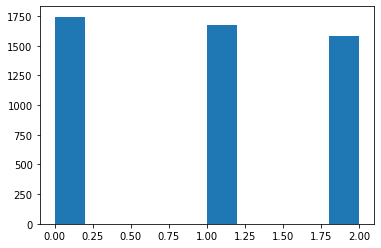

In [84]:
%matplotlib inline 
plt.hist(category)

#**모델링 결과 샘플링**


**개선 방안**
- pre-truncate: not good
- reduce batch size: slightly better
- delete line with huge length
- word frequency count (hard to pick one)
- delete stop words
- select nouns


In [ ]:
sample_sent = selected_nouns[5000:6000]
sample_sent = np.array(sample_sent)
sample_lab = trim['category'][5000:6000]
sample_lab = np.array(sample_lab)
sample_sent = sentence_clean(sample_sent)

In [ ]:
sample_category = []
for i in tqdm(range(len(sample_sent))):
  temp = test_sentences([sample_sent[i]])
  sample_category.append(np.argmax(temp))

(array([315.,   0.,   0.,   0.,   0., 352.,   0.,   0.,   0., 333.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

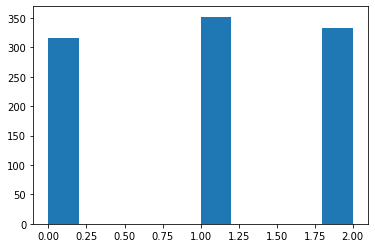

In [ ]:
%matplotlib inline 
plt.hist(sample_category)

In [ ]:
temp = 0
for i in range(len(sample_category)):
    if sample_category[i] != sample_lab[i]: 
      temp = temp + 1
      print('Row: {}, Actual Category: {}, Predicted Category: {}, Number of different rows: {}'.format(i, sample_lab[i], sample_category[i], temp))

Row: 11, Actual Category: 0, Predicted Category: 2, Number of different rows: 1
Row: 27, Actual Category: 0, Predicted Category: 2, Number of different rows: 2
Row: 30, Actual Category: 0, Predicted Category: 2, Number of different rows: 3
Row: 48, Actual Category: 2, Predicted Category: 1, Number of different rows: 4
Row: 51, Actual Category: 2, Predicted Category: 0, Number of different rows: 5
Row: 54, Actual Category: 2, Predicted Category: 0, Number of different rows: 6
Row: 56, Actual Category: 1, Predicted Category: 0, Number of different rows: 7
Row: 60, Actual Category: 2, Predicted Category: 0, Number of different rows: 8
Row: 82, Actual Category: 0, Predicted Category: 1, Number of different rows: 9
Row: 84, Actual Category: 0, Predicted Category: 1, Number of different rows: 10
Row: 93, Actual Category: 1, Predicted Category: 0, Number of different rows: 11
Row: 97, Actual Category: 2, Predicted Category: 0, Number of different rows: 12
Row: 112, Actual Category: 0, Predict

In [ ]:
confusion_matrix(sample_lab, sample_category)

array([[278,  12,  20],
       [  8, 333,   5],
       [ 29,   7, 308]])

In [ ]:
test_sentences([sample_sent[4]])

array([[-2.2629879, -2.302663 ,  5.036036 ]], dtype=float32)

#**파일 출력**

In [85]:
from google.colab import files

In [86]:
output = pd.DataFrame(category, columns=['category'])
output['index'] = output.index
output = output.iloc[:,[1,0]]
print(output.head())

   index  category
0      0         2
1      1         2
2      2         1
3      3         0
4      4         2


In [97]:
output.to_csv('/content/drive/My Drive/NLP_practice/Blue-House/data.csv')